<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [2]:
# загружаем данные 
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [3]:
df.shape

(26496, 1)

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [6]:
# проверка, что индекс монотонный
df.index.is_monotonic

True

In [7]:
# проверка на пропуски
df.isna().sum()

num_orders    0
dtype: int64

In [8]:
# общий анализ данных
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
# описательная статистика
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Выполним ресемплирование по одному часу.

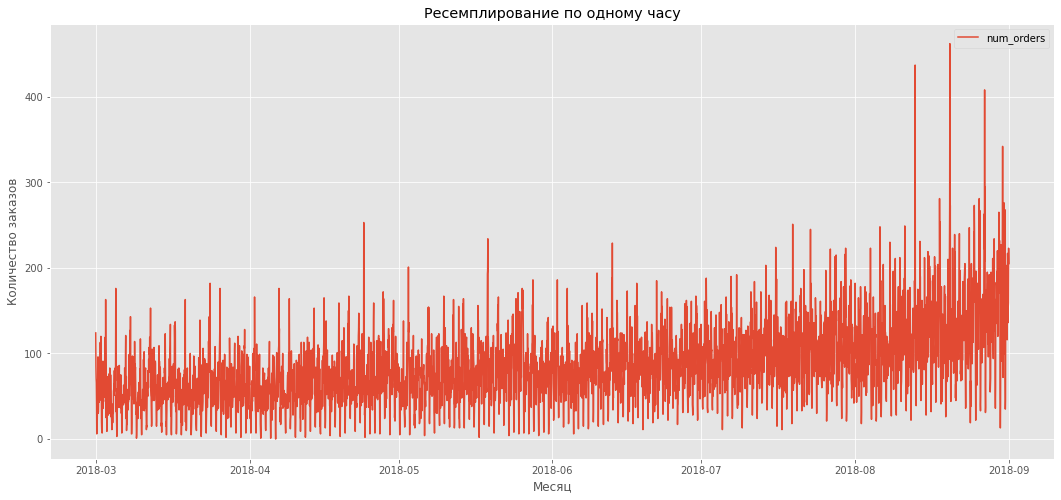

In [10]:
df = df.resample('1H').sum()
plt.figure(figsize=(18, 8))
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Ресемплирование по одному часу')
sns.lineplot(data=df);

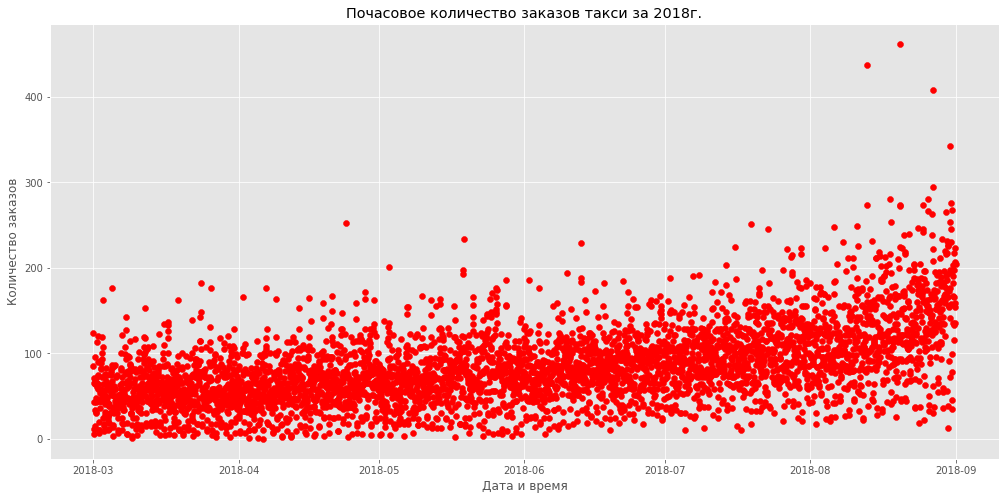

In [11]:
# Создание фигуры 
fig, ax = plt.subplots(figsize=(17, 8))

# Добавление x-axis и y-axis
ax.scatter(df.index[0:],
           df['num_orders'],
           color='r')

# Установление заголовоков и названий для осей
ax.set(xlabel="Дата и время",
       ylabel="Количество заказов",
       title="Почасовое количество заказов такси за 2018г.")

plt.show()

<b>Вывод:</b>
1. Пропуски отсутствуют;
2. Даты и время расположены в хронологическом ли порядке;
3. Тренд на количество заказов в час положительный.

## Анализ

Проверим, является ли наш ряд стационарным. Для этого применим Тест Дики — Фуллера.

H0: Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени. <br>
H1: Временной ряд является стационарным.

In [12]:
p_value = adfuller(df)[1]

if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


Разложим временной ряд на тренд, сезонность и остаток

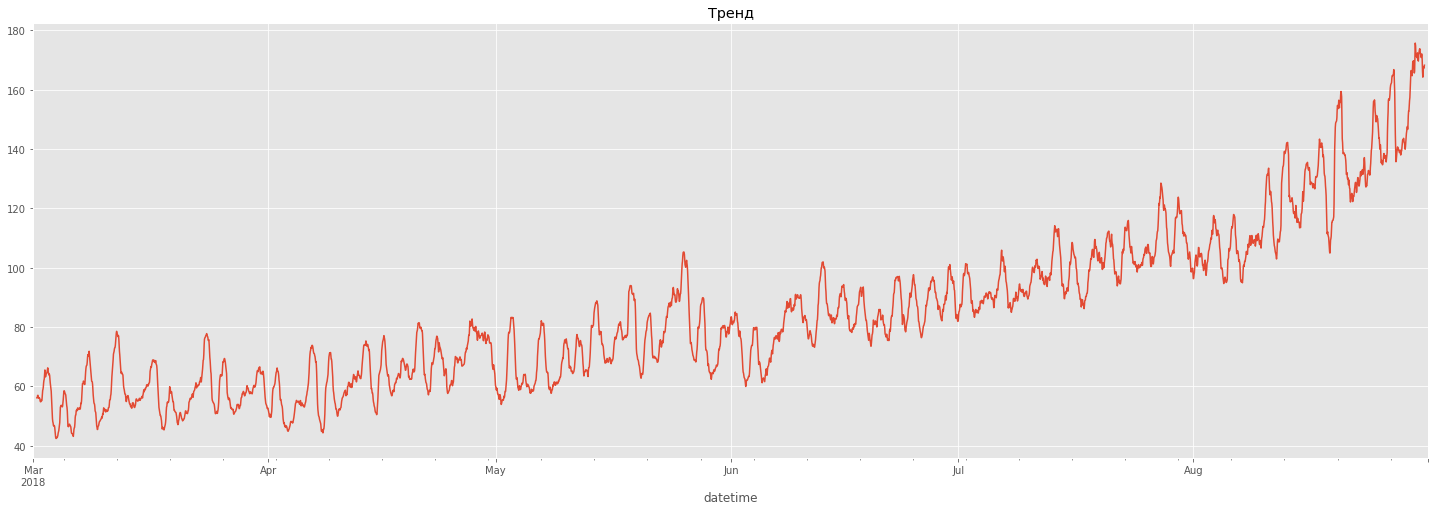

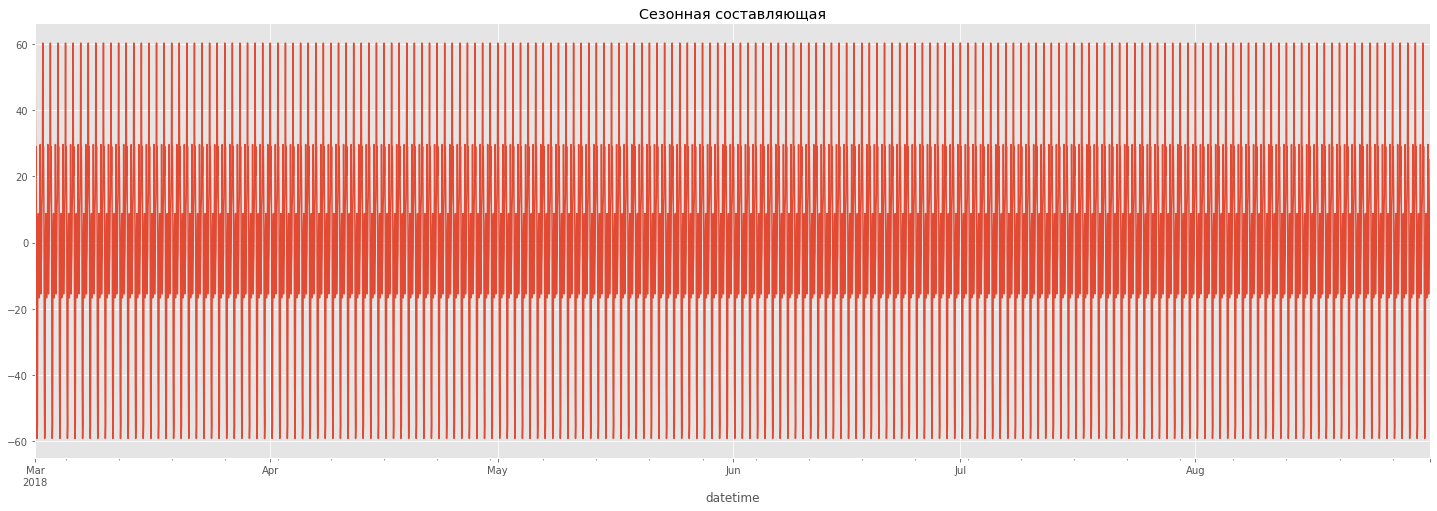

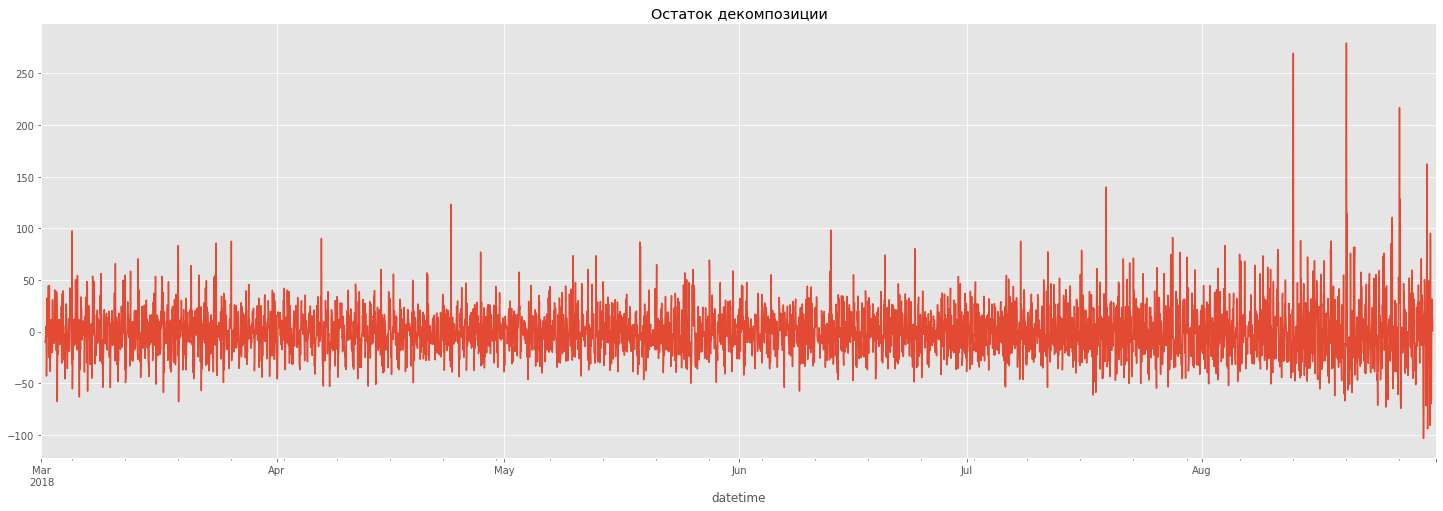

In [13]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot(figsize = (25, 8), title = 'Тренд')
plt.show()
decomposed.seasonal.plot(figsize = (25, 8), title = 'Сезонная составляющая')
plt.show()
decomposed.resid.plot(figsize = (25, 8), title = 'Остаток декомпозиции')
plt.show()

Построим график с сезонной составляющей (переодически повторяющейся компонентой) за один день середины (15) августа 2018 г. (перед резким повышением тренда в сентябре)

<AxesSubplot:title={'center':'Сезонная составляющая'}, xlabel='datetime'>

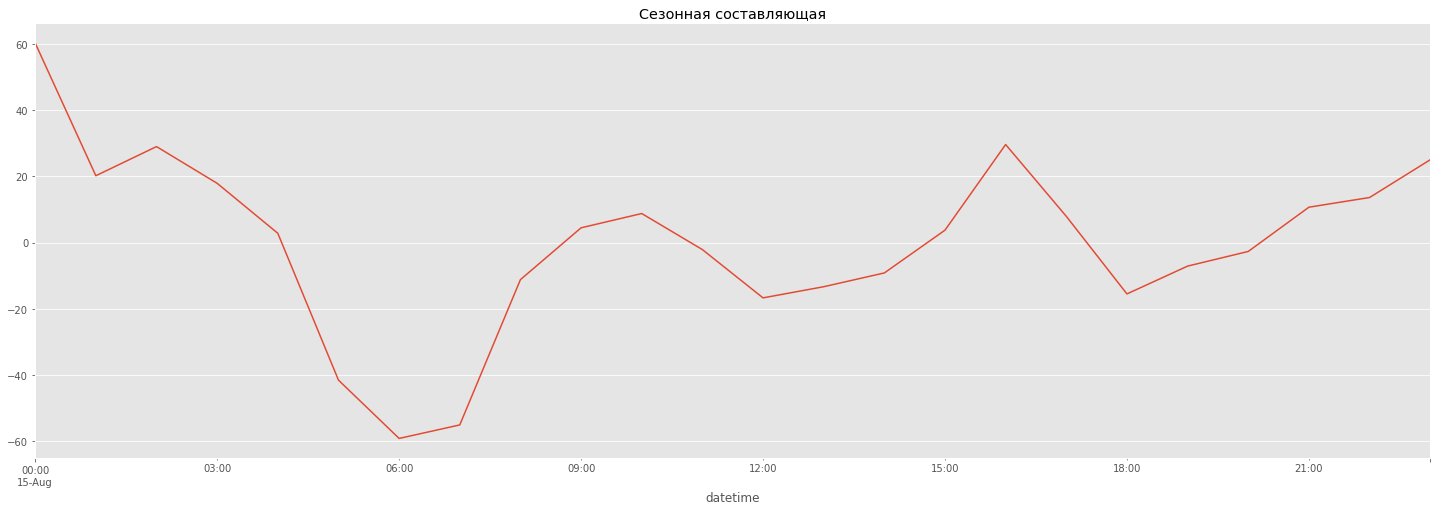

In [14]:
decomposed.seasonal['2018-08-15'].plot(figsize = (25, 8), title = 'Сезонная составляющая')

Посмотрим на сезонную составляющую в другой середины (15), например, мая 2018 г.

<AxesSubplot:title={'center':'Сезонная составляющая'}, xlabel='datetime'>

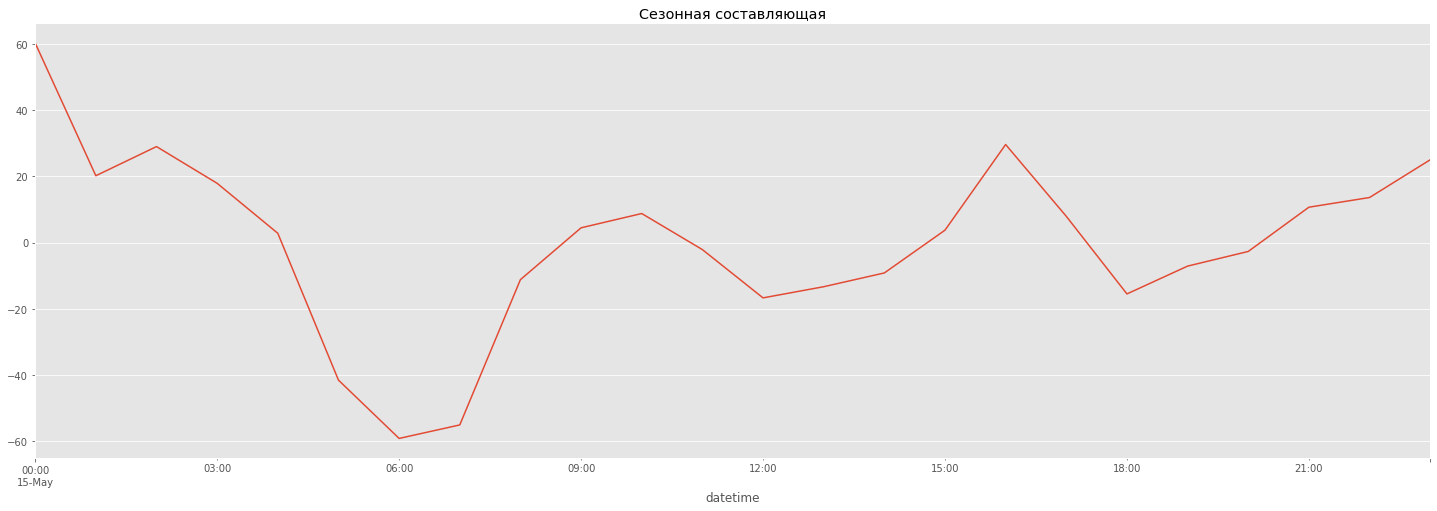

In [15]:
decomposed.seasonal['2018-05-15'].plot(figsize = (25, 8), title = 'Сезонная составляющая')

Оба графика выглядят идентичными друг другу, то есть сезонность кажется независимой от времени.

<b>Вывод:</b>
   1. Благодаря тесту Дики — Фуллера убедились, что наш ряд является стационарным.
   2. Сезонная составляющая не меняется с течением времени.
   3. Пик заказов - ночное время с 00:00 до 03:00. Минимум - в 06:00.

## Обучение

In [16]:
# Создание функции для признаков
def make_features(df, max_lag, rolling_mean_size):
    # Формирование календарных признаков
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    # Формирование отстающих признаков
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    # Добавление признака скользящего среднего
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(df, 10, 24)

In [18]:
df.head(11)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN


In [19]:
# разбиение на выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [20]:
# Создание признаков и целевых признаков данных
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']


X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

print('Размер обучающей выборки', X_train.shape)
print('Размер тестовой выборки', X_test.shape)

Размер обучающей выборки (3950, 13)
Размер тестовой выборки (442, 13)


<b>Линейная регрессия</b>

In [21]:
%%time
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

CPU times: user 91.3 ms, sys: 824 µs, total: 92.1 ms
Wall time: 100 ms


LinearRegression(n_jobs=-1)

In [36]:
%%time
model.predict(X_train)

CPU times: user 3.49 ms, sys: 61 µs, total: 3.55 ms
Wall time: 2.28 ms


array([ 59.30918233,  69.30946476,  85.18743718, ..., 115.34760059,
       138.10683491, 116.94547936])

<b>Дерево принятий решений</b>

In [22]:
tscv = TimeSeriesSplit(n_splits=8)

In [23]:
%%time
model_DT = DecisionTreeRegressor(random_state=42)
params_DT = {
    'max_depth' : [12,16,20,24],
    'min_samples_leaf': [3,5,7,9],
    'min_samples_split': [3,5,7,9]
}
grid_DT = GridSearchCV(model_DT, params_DT, n_jobs=-1, scoring='neg_mean_squared_error', cv=tscv, verbose=1)
grid_DT.fit(X_train, y_train)

Fitting 8 folds for each of 64 candidates, totalling 512 fits
CPU times: user 7.99 s, sys: 83.5 ms, total: 8.08 s
Wall time: 8.11 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [12, 16, 20, 24],
                         'min_samples_leaf': [3, 5, 7, 9],
                         'min_samples_split': [3, 5, 7, 9]},
             scoring='neg_mean_squared_error', verbose=1)

In [24]:
grid_DT.best_params_

{'max_depth': 12, 'min_samples_leaf': 9, 'min_samples_split': 3}

In [25]:
(grid_DT.best_score_ * (-1)) ** 0.5

28.322148125321675

In [26]:
%%time
grid_DT.best_estimator_.fit(X_train, y_train)

CPU times: user 24.3 ms, sys: 98 µs, total: 24.4 ms
Wall time: 23.9 ms


DecisionTreeRegressor(max_depth=12, min_samples_leaf=9, min_samples_split=3,
                      random_state=42)

In [35]:
%%time 
grid_DT.best_estimator_.predict(X_train)

CPU times: user 3.91 ms, sys: 68 µs, total: 3.98 ms
Wall time: 2.72 ms


array([112.7       , 107.84615385,  49.09090909, ..., 116.09090909,
       101.41666667,  88.33846154])

<b>CatBoost</b>

In [27]:
%%time
cat = CatBoostRegressor(random_state=42, loss_function='RMSE', iterations=301)
params_cat = {
    'depth' : [4,8,12],
    'learning_rate': [0.2]
}
grid_cat = GridSearchCV(cat, params_cat, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error', verbose=31)
grid_cat.fit(X_train, y_train)

Fitting 8 folds for each of 3 candidates, totalling 24 fits
[CV 1/8; 1/3] START depth=4, learning_rate=0.2..................................
0:	learn: 26.6537063	total: 51.4ms	remaining: 15.4s
1:	learn: 24.7628960	total: 52.1ms	remaining: 7.79s
2:	learn: 23.1608504	total: 52.7ms	remaining: 5.23s
3:	learn: 21.8723969	total: 53.3ms	remaining: 3.96s
4:	learn: 21.2845904	total: 53.9ms	remaining: 3.19s
5:	learn: 20.6788655	total: 54.5ms	remaining: 2.68s
6:	learn: 20.0436113	total: 55ms	remaining: 2.31s
7:	learn: 19.5770565	total: 55.6ms	remaining: 2.04s
8:	learn: 18.9233978	total: 56.1ms	remaining: 1.82s
9:	learn: 18.2739914	total: 56.6ms	remaining: 1.65s
10:	learn: 17.7404174	total: 57.2ms	remaining: 1.51s
11:	learn: 17.4102329	total: 57.9ms	remaining: 1.39s
12:	learn: 17.1926104	total: 58.4ms	remaining: 1.29s
13:	learn: 16.9874418	total: 58.9ms	remaining: 1.21s
14:	learn: 16.8210883	total: 59.5ms	remaining: 1.13s
15:	learn: 16.6787251	total: 59.9ms	remaining: 1.07s
16:	learn: 16.5079933	t

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7faca3ea1f70>,
             n_jobs=-1,
             param_grid={'depth': [4, 8, 12], 'learning_rate': [0.2]},
             scoring='neg_mean_squared_error', verbose=31)

In [33]:
(grid_cat.best_score_ * (-1)) ** 0.5

25.087404222179664

In [28]:
%%time
grid_cat.best_estimator_.fit(X_train, y_train)

0:	learn: 35.5396242	total: 1.51ms	remaining: 454ms
1:	learn: 33.1107383	total: 3.02ms	remaining: 451ms
2:	learn: 31.5580809	total: 4.33ms	remaining: 430ms
3:	learn: 30.1735064	total: 5.56ms	remaining: 413ms
4:	learn: 28.8608761	total: 6.89ms	remaining: 408ms
5:	learn: 28.1254367	total: 8.2ms	remaining: 403ms
6:	learn: 27.1919922	total: 9.44ms	remaining: 396ms
7:	learn: 26.7797866	total: 10.7ms	remaining: 393ms
8:	learn: 26.3202994	total: 12ms	remaining: 389ms
9:	learn: 25.8377881	total: 13.3ms	remaining: 387ms
10:	learn: 25.6056880	total: 14.5ms	remaining: 382ms
11:	learn: 25.5566516	total: 15.6ms	remaining: 375ms
12:	learn: 25.3451019	total: 16.8ms	remaining: 371ms
13:	learn: 25.1037448	total: 18ms	remaining: 368ms
14:	learn: 25.0650140	total: 19.2ms	remaining: 365ms
15:	learn: 25.0334329	total: 20ms	remaining: 356ms
16:	learn: 24.7165981	total: 21.2ms	remaining: 355ms
17:	learn: 24.5174151	total: 22.5ms	remaining: 354ms
18:	learn: 24.3533031	total: 23.7ms	remaining: 352ms
19:	learn:

In [34]:
%%time 
grid_cat.best_estimator_.predict(X_train)

CPU times: user 4.12 ms, sys: 2 µs, total: 4.13 ms
Wall time: 2.86 ms


array([110.70088717,  99.5867646 ,  66.29540168, ..., 131.36533674,
       100.73827741, 109.86536691])

<b>Вывод:</b>
<table class="iksweb">
	<tbody>
		<tr>
			<td>-</td>
			<td>Линейная регрессия</td>
			<td>Дерево принятия решений</td>
			<td>CatBoost</td>
		</tr>
		<tr>
			<td>Лучший скоринг</td>
			<td></td>
			<td>28.3221</td>
            <td>25.0874</td>
		</tr>
		<tr>
			<td>Время обучения</td>
			<td>100 ms</td>
			<td>23.9 ms</td>
			<td>930 ms</td>
		</tr>
		<tr>
			<td>Время предсказания тренировочной выборки</td>
			<td>2.28 ms</td>
			<td>2.72 ms</td>
			<td>2.86 ms</td>
		</tr>
	</tbody>
</table>

Лучший результат у CatBoost. Проверим результат на тестовой выборке.

## Тестирование

In [37]:
%%time 
predictions = grid_cat.best_estimator_.predict(X_test)
print(mean_squared_error(predictions, y_test, squared = False))

45.27604857004527
CPU times: user 3.17 ms, sys: 0 ns, total: 3.17 ms
Wall time: 3 ms


<b>Общий вывод:</b> Для предсказания тестовой выборки была выбрана модель CatBoost. Модель показала резульат RMSE равный 45.2760, что является допустимым значением качества для заказчика (требование >=48 RMSE)

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48